In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output is binary: stock will go up or down.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* 0 if price will go down
* 1 if price will go up

In [201]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [202]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

CHUNK_LENGTH = 30
observed_chunks, observation_results = investor_observes_stocks_for(x_days=CHUNK_LENGTH, then_buy_stocks=True, and_sells_them=True, after_y_days=5)

In [203]:
observed_chunks[0].head(10)

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000
5,5,2000-02-29,1348.050049,1369.630005,1348.050049,1366.420044,1366.420044,1204300000
6,6,2000-03-01,1366.420044,1383.459961,1366.420044,1379.189941,1379.189941,1274100000
7,7,2000-03-02,1379.189941,1386.560059,1370.349976,1381.760010,1381.760010,1198600000
8,8,2000-03-03,1381.760010,1410.880005,1381.760010,1409.170044,1409.170044,1150300000
9,9,2000-03-06,1409.170044,1409.739990,1384.750000,1391.280029,1391.280029,1029000000


**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [204]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(list(map(lambda x: x, label_array)))

categorical_labels(observation_results)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [205]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (CHUNK_LENGTH, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 30, 16)            336       
_________________________________________________________________
batch_normalization_31 (Batc (None, 30, 16)            64        
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 30, 16)            0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 16)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 30, 8)             520       
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 8)             32        
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 30, 8)           

In [206]:
from keras.optimizers import Nadam

model.compile(optimizer=Nadam(lr=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [211]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(to_categorical(observation_results))

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)


RANDOM_SPLIT = False
TEST_SIZE = 0.5

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2497, 30, 5), (2497, 2), (2498, 30, 5), (2498, 2))

In [212]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=128, 
                    epochs=100, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [reduce_lr, checkpointer])

Train on 2497 samples, validate on 2498 samples
Epoch 1/100
2497/2497 [==============================] - 0s 62us/step - loss: 0.6947 - accuracy: 0.5234 - val_loss: 0.7168 - val_accuracy: 0.4536

Epoch 00001: val_loss improved from inf to 0.71684, saving model to model.hdf5
Epoch 2/100
2497/2497 [==============================] - 0s 54us/step - loss: 0.6940 - accuracy: 0.5122 - val_loss: 0.7156 - val_accuracy: 0.4632

Epoch 00002: val_loss improved from 0.71684 to 0.71561, saving model to model.hdf5
Epoch 3/100
2497/2497 [==============================] - 0s 53us/step - loss: 0.6926 - accuracy: 0.5130 - val_loss: 0.7524 - val_accuracy: 0.4488

Epoch 00003: val_loss did not improve from 0.71561
Epoch 4/100
2497/2497 [==============================] - 0s 50us/step - loss: 0.6923 - accuracy: 0.5146 - val_loss: 0.7152 - val_accuracy: 0.4692

Epoch 00004: val_loss improved from 0.71561 to 0.71523, saving model to model.hdf5
Epoch 5/100
2497/2497 [==============================] - 0s 52us/ste

2497/2497 [==============================] - 0s 50us/step - loss: 0.6922 - accuracy: 0.5218 - val_loss: 0.9848 - val_accuracy: 0.4488

Epoch 00041: val_loss did not improve from 0.67120
Epoch 42/100
2497/2497 [==============================] - 0s 49us/step - loss: 0.6932 - accuracy: 0.5218 - val_loss: 0.7641 - val_accuracy: 0.4692

Epoch 00042: val_loss did not improve from 0.67120
Epoch 43/100
2497/2497 [==============================] - 0s 52us/step - loss: 0.6916 - accuracy: 0.5238 - val_loss: 1.4864 - val_accuracy: 0.4347

Epoch 00043: val_loss did not improve from 0.67120
Epoch 44/100
2497/2497 [==============================] - 0s 53us/step - loss: 0.6942 - accuracy: 0.5154 - val_loss: 1.1856 - val_accuracy: 0.4311

Epoch 00044: val_loss did not improve from 0.67120
Epoch 45/100
2497/2497 [==============================] - 0s 52us/step - loss: 0.6915 - accuracy: 0.5270 - val_loss: 0.8432 - val_accuracy: 0.4492

Epoch 00045: val_loss did not improve from 0.67120
Epoch 46/100
2497/

2497/2497 [==============================] - 0s 51us/step - loss: 0.6913 - accuracy: 0.5483 - val_loss: 1.1180 - val_accuracy: 0.4039

Epoch 00082: val_loss did not improve from 0.67120
Epoch 83/100
2497/2497 [==============================] - 0s 51us/step - loss: 0.6911 - accuracy: 0.5234 - val_loss: 1.1397 - val_accuracy: 0.4291

Epoch 00083: val_loss did not improve from 0.67120
Epoch 84/100
2497/2497 [==============================] - 0s 50us/step - loss: 0.6914 - accuracy: 0.5226 - val_loss: 0.9576 - val_accuracy: 0.4508

Epoch 00084: val_loss did not improve from 0.67120
Epoch 85/100
2497/2497 [==============================] - 0s 50us/step - loss: 0.6921 - accuracy: 0.5306 - val_loss: 0.8639 - val_accuracy: 0.4544

Epoch 00085: val_loss did not improve from 0.67120
Epoch 86/100
2497/2497 [==============================] - 0s 51us/step - loss: 0.6905 - accuracy: 0.5366 - val_loss: 1.0395 - val_accuracy: 0.4528

Epoch 00086: val_loss did not improve from 0.67120
Epoch 87/100
2497/

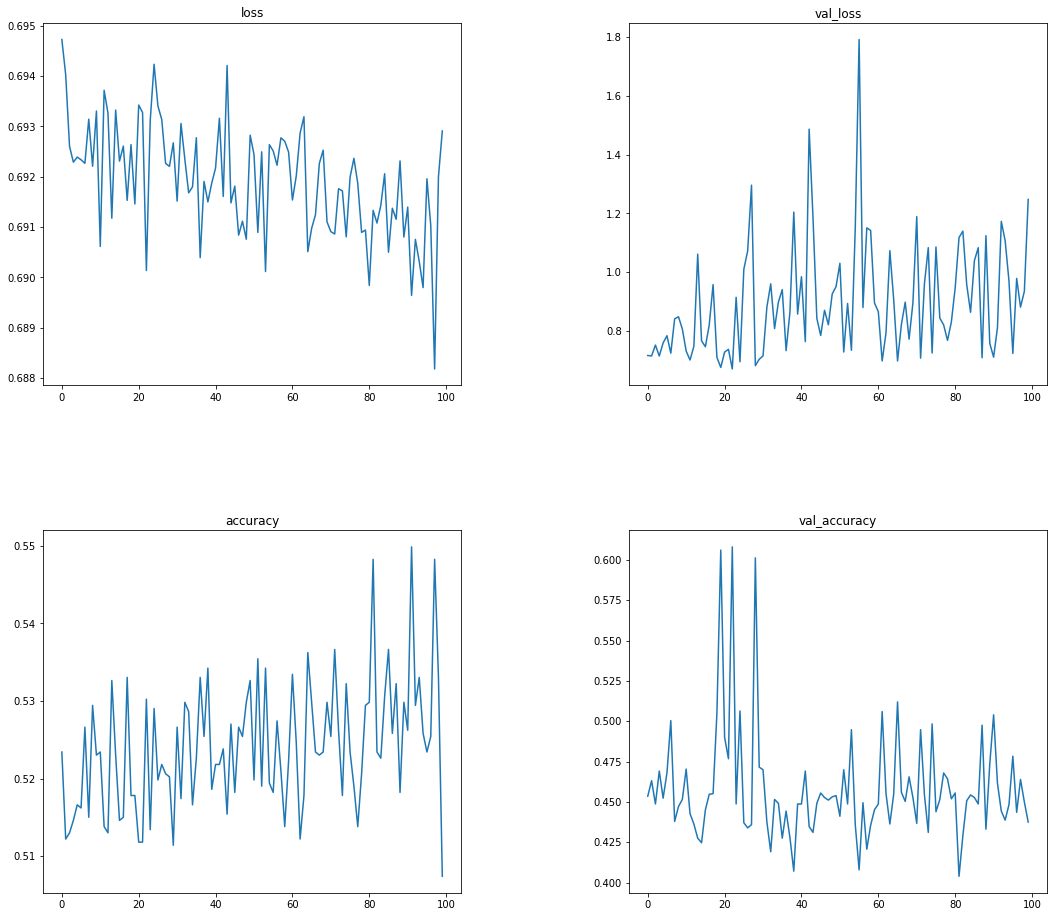

In [213]:
history_dict = history.history
history_dict.keys()

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(history_dict['loss'])
plt.subplot(2, 2, 2)
plt.title('val_loss')
plt.plot(history_dict['val_loss'])
plt.subplot(2, 2, 3)
plt.title('accuracy')
plt.plot(history_dict['accuracy'])
plt.subplot(2, 2, 4)
plt.title('val_accuracy')
plt.plot(history_dict['val_accuracy'])

plt.show()

(array([493.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 767.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

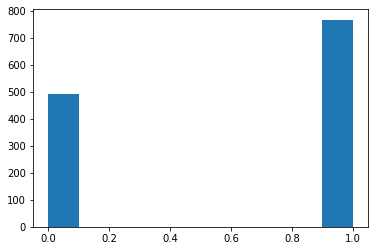

In [174]:
labels = np.argmax(Y_test, axis=1)

plt.hist(labels)

(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

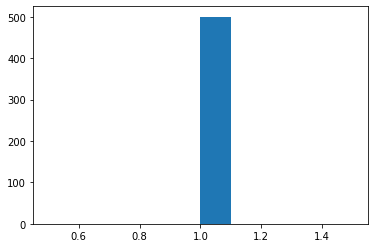

In [210]:
preds = model.predict(np.array(X_test))

plt.hist(np.argmax(preds, axis=1))